<a href="https://colab.research.google.com/github/CarolinaPiedrahita/Modelo-de-opciones-de-pago/blob/main/Modelo_de_opciones_de_pago.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **1. Instalación y Importación de Librerías**

In [2]:
!pip install pandas numpy scikit-learn xgboost matplotlib seaborn

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.metrics import f1_score, roc_auc_score, confusion_matrix, classification_report




# **2.Carga y Exploración de Datos**

In [8]:
# Leer archivos CSV desde el directorio sample_data
oot_data = pd.read_csv('/content/sample_data/prueba_op_base_pivot_var_rpta_alt_enmascarado_oot.csv', low_memory=False)
train_data = pd.read_csv('/content/sample_data/prueba_op_base_pivot_var_rpta_alt_enmascarado_trtest.csv', low_memory=False)
cuotas_pagos_data = pd.read_csv('/content/sample_data/prueba_op_maestra_cuotas_pagos_mes_hist_enmascarado_completa.csv', on_bad_lines='skip', low_memory=False)
customer_data = pd.read_csv('/content/sample_data/prueba_op_master_customer_data_enmascarado_completa.csv', low_memory=False)
probabilidad_data = pd.read_csv('/content/sample_data/prueba_op_probabilidad_oblig_base_hist_enmascarado_completa.csv', on_bad_lines='skip', low_memory=False)
sample_submission = pd.read_csv('/content/sample_data/sample_submission.csv', low_memory=False)

# Mostrar las primeras filas de cada DataFrame para verificar
print("oot_data:\n", oot_data.head())
print("train_data:\n", train_data.head())
print("cuotas_pagos_data:\n", cuotas_pagos_data.head())
print("customer_data:\n", customer_data.head())
print("probabilidad_data:\n", probabilidad_data.head())
print("sample_submission:\n", sample_submission.head())


oot_data:
    nit_enmascarado  num_oblig_orig_enmascarado  num_oblig_enmascarado  \
0           257335                      444821                 635511   
1            59584                      350400                 730364   
2           397604                      973821                 106521   
3           368086                      382995                 696856   
4           255009                      434238                 645924   

   fecha_var_rpta_alt  
0              202401  
1              202401  
2              202401  
3              202401  
4              202401  
train_data:
    nit_enmascarado  num_oblig_orig_enmascarado  num_oblig_enmascarado  \
0           630611                      219718                 863073   
1            59412                      789567                 290775   
2           277595                     1045909                  34433   
3            26897                      585786                 494556   
4            24588          

# **Exploración**

In [9]:
# Información general de los datasets
print("Información general del dataset de entrenamiento:")
print(train_data.info())

print("\nInformación general del dataset OOT:")
print(oot_data.info())

print("\nInformación general del dataset de probabilidad:")
print(probabilidad_data.info())

print("\nInformación general del dataset de cuotas y pagos:")
print(cuotas_pagos_data.info())

print("\nInformación general del dataset de clientes:")
print(customer_data.info())

# Estadísticas descriptivas para variables numéricas
print("\nEstadísticas descriptivas de variables numéricas (Train Data):")
print(train_data.describe())

print("\nEstadísticas descriptivas de variables numéricas (Probabilidad Data):")
print(probabilidad_data.describe())

print("\nEstadísticas descriptivas de variables numéricas (Cuotas Pagos Data):")
print(cuotas_pagos_data.describe())

print("\nEstadísticas descriptivas de variables numéricas (Customer Data):")
print(customer_data.describe())

# Estadísticas descriptivas para variables categóricas (si existen)
categorical_features_train = train_data.select_dtypes(include=['object']).columns
categorical_features_probabilidad = probabilidad_data.select_dtypes(include=['object']).columns
categorical_features_cuotas_pagos = cuotas_pagos_data.select_dtypes(include=['object']).columns
categorical_features_customer = customer_data.select_dtypes(include=['object']).columns

if len(categorical_features_train) > 0:
    print("\nDistribución de variables categóricas (Train Data):")
    print(train_data[categorical_features_train].describe())
else:
    print("\nNo hay variables categóricas en Train Data.")

if len(categorical_features_probabilidad) > 0:
    print("\nDistribución de variables categóricas (Probabilidad Data):")
    print(probabilidad_data[categorical_features_probabilidad].describe())
else:
    print("\nNo hay variables categóricas en Probabilidad Data.")

if len(categorical_features_cuotas_pagos) > 0:
    print("\nDistribución de variables categóricas (Cuotas Pagos Data):")
    print(cuotas_pagos_data[categorical_features_cuotas_pagos].describe())
else:
    print("\nNo hay variables categóricas en Cuotas Pagos Data.")

if len(categorical_features_customer) > 0:
    print("\nDistribución de variables categóricas (Customer Data):")
    print(customer_data[categorical_features_customer].describe())
else:
    print("\nNo hay variables categóricas en Customer Data.")


Información general del dataset de entrenamiento:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20437 entries, 0 to 20436
Data columns (total 49 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   nit_enmascarado                  20437 non-null  int64  
 1   num_oblig_orig_enmascarado       20437 non-null  int64  
 2   num_oblig_enmascarado            20437 non-null  int64  
 3   fecha_var_rpta_alt               20437 non-null  int64  
 4   var_rpta_alt                     20437 non-null  int64  
 5   tipo_var_rpta_alt                20437 non-null  object 
 6   banca                            20437 non-null  object 
 7   segmento                         20437 non-null  object 
 8   producto                         20437 non-null  object 
 9   producto_cons                    20437 non-null  object 
 10  aplicativo                       20437 non-null  object 
 11  min_mora                      

/usr/local/lib/python3.10/dist-packages/pandas/core/nanops.py:1010: RuntimeWarning: invalid value encountered in subtract
  sqr = _ensure_numeric((avg - values) ** 2)


                  producto aplicativo  segmento marca_pago ajustes_banco
count                79171      79171     79171      79171         79171
unique                  18          7         6          8             3
top     TARJETA DE CREDITO          L  PERSONAL   PAGO_MAS            NO
freq                 36403      40828     50061      26565         77668

Distribución de variables categóricas (Customer Data):
               tipo_cli ctrl_terc genero_cli estado_civil tipo_vivienda  \
count             31730     31730      31139        29041         10081   
unique                2         4          2            8             4   
top     PERSONA NATURAL   CLIENTE          M      SOLTERO      FAMILIAR   
freq              31141     30314      15584        13874          5306   

       nivel_academico      ocup  act_econom    sector           subsector  \
count            13683     30004       29376     29242               29242   
unique               7        14           8   

# **3. Preprocesamiento de Datos**

Manejo de valores nulos y datos duplicados:

In [10]:
# Verificar valores nulos y duplicados
print("\nValores nulos en el dataset de entrenamiento:")
print(train_data.isnull().sum())

print("\nValores nulos en el dataset OOT:")
print(oot_data.isnull().sum())

print("\nValores nulos en el dataset de probabilidad:")
print(probabilidad_data.isnull().sum())

print("\nValores nulos en el dataset de cuotas y pagos:")
print(cuotas_pagos_data.isnull().sum())

print("\nValores nulos en el dataset de clientes:")
print(customer_data.isnull().sum())

print("\nDatos duplicados en el dataset de entrenamiento:")
print(train_data.duplicated().sum())

print("\nDatos duplicados en el dataset OOT:")
print(oot_data.duplicated().sum())

print("\nDatos duplicados en el dataset de probabilidad:")
print(probabilidad_data.duplicated().sum())

print("\nDatos duplicados en el dataset de cuotas y pagos:")
print(cuotas_pagos_data.duplicated().sum())

print("\nDatos duplicados en el dataset de clientes:")
print(customer_data.duplicated().sum())

# Eliminar duplicados
train_data.drop_duplicates(inplace=True)
oot_data.drop_duplicates(inplace=True)
probabilidad_data.drop_duplicates(inplace=True)
cuotas_pagos_data.drop_duplicates(inplace=True)
customer_data.drop_duplicates(inplace=True)

# Manejo de valores nulos: llenar valores nulos con la mediana para numéricos y con el valor más frecuente para categóricos
for col in train_data.columns:
    if train_data[col].dtype == 'object':
        train_data[col].fillna(train_data[col].mode()[0], inplace=True)
    else:
        train_data[col].fillna(train_data[col].median(), inplace=True)

for col in oot_data.columns:
    if oot_data[col].dtype == 'object':
        oot_data[col].fillna(oot_data[col].mode()[0], inplace=True)
    else:
        oot_data[col].fillna(oot_data[col].median(), inplace=True)

for col in probabilidad_data.columns:
    if probabilidad_data[col].dtype == 'object':
        probabilidad_data[col].fillna(probabilidad_data[col].mode()[0], inplace=True)
    else:
        probabilidad_data[col].fillna(probabilidad_data[col].median(), inplace=True)

for col in cuotas_pagos_data.columns:
    if cuotas_pagos_data[col].dtype == 'object':
        cuotas_pagos_data[col].fillna(cuotas_pagos_data[col].mode()[0], inplace=True)
    else:
        cuotas_pagos_data[col].fillna(cuotas_pagos_data[col].median(), inplace=True)

for col in customer_data.columns:
    if customer_data[col].dtype == 'object':
        customer_data[col].fillna(customer_data[col].mode()[0], inplace=True)
    else:
        customer_data[col].fillna(customer_data[col].median(), inplace=True)

# Verificar nuevamente si hay valores nulos
print("\nValores nulos en el dataset de entrenamiento después de limpieza:")
print(train_data.isnull().sum())

print("\nValores nulos en el dataset OOT después de limpieza:")
print(oot_data.isnull().sum())

print("\nValores nulos en el dataset de probabilidad después de limpieza:")
print(probabilidad_data.isnull().sum())

print("\nValores nulos en el dataset de cuotas y pagos después de limpieza:")
print(cuotas_pagos_data.isnull().sum())

print("\nValores nulos en el dataset de clientes después de limpieza:")
print(customer_data.isnull().sum())



Valores nulos en el dataset de entrenamiento:
nit_enmascarado                        0
num_oblig_orig_enmascarado             0
num_oblig_enmascarado                  0
fecha_var_rpta_alt                     0
var_rpta_alt                           0
tipo_var_rpta_alt                      0
banca                                  0
segmento                               0
producto                               0
producto_cons                          0
aplicativo                             0
min_mora                               0
max_mora                               0
dias_mora_fin                          0
rango_mora                             0
vlr_obligacion                        31
vlr_vencido                            0
saldo_capital                          0
endeudamiento                          0
desc_alternativa1                      0
desc_alternativa2                      0
desc_alternativa3                      0
cant_alter_posibles                    0
alter_posi

# 4.Integración de Datos : integramos todos los datasets para tener un conjunto de datos completo y listo para el modelado

In [11]:
# Mostrar las columnas de cada dataset para identificar las claves comunes
print("Columnas del dataset de entrenamiento:")
print(train_data.columns)

print("\nColumnas del dataset de probabilidad:")
print(probabilidad_data.columns)

print("\nColumnas del dataset de cuotas y pagos:")
print(cuotas_pagos_data.columns)

print("\nColumnas del dataset de clientes:")
print(customer_data.columns)


Columnas del dataset de entrenamiento:
Index(['nit_enmascarado', 'num_oblig_orig_enmascarado',
       'num_oblig_enmascarado', 'fecha_var_rpta_alt', 'var_rpta_alt',
       'tipo_var_rpta_alt', 'banca', 'segmento', 'producto', 'producto_cons',
       'aplicativo', 'min_mora', 'max_mora', 'dias_mora_fin', 'rango_mora',
       'vlr_obligacion', 'vlr_vencido', 'saldo_capital', 'endeudamiento',
       'desc_alternativa1', 'desc_alternativa2', 'desc_alternativa3',
       'cant_alter_posibles', 'alter_posible1_2', 'alter_posible2_2',
       'alter_posible3_2', 'cant_gestiones', 'cant_gestiones_binario', 'rpc',
       'promesas_cumplidas', 'cant_promesas_cumplidas_binario', 'cant_acuerdo',
       'cant_acuerdo_binario', 'descripcion_ranking_mejor_ult',
       'descripcion_ranking_post_ult', 'marca_alt_rank', 'marca_alt_apli',
       'valor_cuota_mes', 'pago_cuota', 'porc_pago_cuota', 'pago_mes',
       'porc_pago_mes', 'pagos_tanque', 'marca_debito_mora',
       'alternativa_aplicada_agr', 'ma

In [12]:
# Convertir las columnas comunes a str para asegurar una fusión correcta
common_cols = ['nit_enmascarado', 'num_oblig_enmascarado']

for col in common_cols:
    train_data[col] = train_data[col].astype(str)
    probabilidad_data[col] = probabilidad_data[col].astype(str)
    cuotas_pagos_data[col] = cuotas_pagos_data[col].astype(str)
    customer_data['nit_enmascarado'] = customer_data['nit_enmascarado'].astype(str)

# Fusionar datasets basados en las columnas comunes
train_full = train_data.merge(probabilidad_data, on=common_cols, how='left')
train_full = train_full.merge(cuotas_pagos_data, on=common_cols, how='left')
train_full = train_full.merge(customer_data, on='nit_enmascarado', how='left')  # Aquí solo fusionamos por 'nit_enmascarado'

# Verificar la fusión
print("\nDatos fusionados:")
print(train_full.head())
print(train_full.info())



Datos fusionados:
  nit_enmascarado  num_oblig_orig_enmascarado num_oblig_enmascarado  \
0          630611                      219718                863073   
1           59412                      789567                290775   
2          277595                     1045909                 34433   
3           26897                      585786                494556   
4           24588                     1061389                 18953   

   fecha_var_rpta_alt  var_rpta_alt tipo_var_rpta_alt           banca  \
0              202308             1      a_uno_tipo_1  Banca Personas   
1              202312             1      a_uno_tipo_1  Banca Personas   
2              202312             1      b_uno_tipo_2  Banca Personas   
3              202311             1      a_uno_tipo_1  Banca Personas   
4              202311             1      b_uno_tipo_2  Banca Personas   

      segmento_x          producto_x       producto_cons  ... nicho  \
0       Personal  TARJETA DE CREDITO  Tarjet

In [13]:
# fusionar datasets
common_cols = ['nit_enmascarado', 'num_oblig_enmascarado']

train_full = train_data.merge(probabilidad_data, on=common_cols, how='left')
train_full = train_full.merge(cuotas_pagos_data, on=common_cols, how='left')
train_full = train_full.merge(customer_data, on='nit_enmascarado', how='left')  # Aquí solo fusionamos por 'nit_enmascarado'

# Verificar la fusión
print("\nDatos fusionados:")
print(train_full.head())
print(train_full.info())



Datos fusionados:
  nit_enmascarado  num_oblig_orig_enmascarado num_oblig_enmascarado  \
0          630611                      219718                863073   
1           59412                      789567                290775   
2          277595                     1045909                 34433   
3           26897                      585786                494556   
4           24588                     1061389                 18953   

   fecha_var_rpta_alt  var_rpta_alt tipo_var_rpta_alt           banca  \
0              202308             1      a_uno_tipo_1  Banca Personas   
1              202312             1      a_uno_tipo_1  Banca Personas   
2              202312             1      b_uno_tipo_2  Banca Personas   
3              202311             1      a_uno_tipo_1  Banca Personas   
4              202311             1      b_uno_tipo_2  Banca Personas   

      segmento_x          producto_x       producto_cons  ... nicho  \
0       Personal  TARJETA DE CREDITO  Tarjet

# 5. Análisis de Correlación

In [14]:
# Seleccionar solo las columnas numéricas
numeric_columns = train_full.select_dtypes(include=[np.number]).columns

# Calcular la correlación entre variables numéricas y la variable objetivo
correlation_matrix = train_full[numeric_columns].corr()
print("\nCorrelación entre variables numéricas y la variable objetivo:")
print(correlation_matrix['var_rpta_alt'].sort_values(ascending=False))



Correlación entre variables numéricas y la variable objetivo:
var_rpta_alt                       1.000000
cant_promesas_cumplidas_binario    0.322705
promesas_cumplidas                 0.301906
porc_pago_mes                      0.299229
prob_propension                    0.219454
prob_auto_cura                     0.179173
porc_pago_cuota                    0.143412
pago_mes                           0.137018
cant_alter_posibles                0.124322
pago_cuota                         0.097906
pago_total                         0.093319
porc_pago                          0.069649
ano_nac_cli                        0.049009
f_ult_mantenimiento                0.044335
valor_cuota_mes_x                  0.037660
ingestion_day                      0.025387
vlr_vencido                        0.020600
f_vinc                             0.018678
tot_pasivos                        0.017853
endeudamiento                      0.016304
saldo_capital                      0.013972
vlr_obligacio

La correlación muestra que los clientes que han cumplido promesas de pago y tienen un mayor porcentaje de pago mensual tienen más probabilidades de aceptar opciones de pago. Las variables `cant_promesas_cumplidas_binario`, `promesas_cumplidas`, `porc_pago_mes` y `prob_propension` tienen correlaciones positivas moderadas a altas con la aceptación de opciones de pago. En contraste, más días de mora (`dias_mora_fin`) y menos acuerdos (`cant_acuerdo_binario`) se asocian con una menor probabilidad de aceptación, indicando la influencia negativa de la morosidad y la falta de acuerdos en la aceptación de opciones de pago.

# 6. Análisis de Variables Categóricas

In [15]:
# Análisis de las variables categóricas
categorical_features = train_full.select_dtypes(include=['object']).columns

for feature in categorical_features:
    print(f"\nDistribución de la variable categórica {feature}:")
    print(train_full[feature].value_counts())



Distribución de la variable categórica nit_enmascarado:
nit_enmascarado
205391    11
14715     11
147144    10
248254     9
162162     9
          ..
377361     1
356666     1
487939     1
35854      1
16439      1
Name: count, Length: 17210, dtype: int64

Distribución de la variable categórica num_oblig_enmascarado:
num_oblig_enmascarado
462632     6
345633     6
49389      6
614928     6
806324     6
          ..
1045190    1
401777     1
257585     1
65350      1
382550     1
Name: count, Length: 18385, dtype: int64

Distribución de la variable categórica tipo_var_rpta_alt:
tipo_var_rpta_alt
e_cero_tipo_2    10232
a_uno_tipo_1      6815
b_uno_tipo_2      2837
c_uno_tipo_3       762
d_cero_tipo_1      679
Name: count, dtype: int64

Distribución de la variable categórica banca:
banca
Banca Personas    19134
Independientes     1828
Banca Pyme          363
Name: count, dtype: int64

Distribución de la variable categórica segmento_x:
segmento_x
Personal         13970
Personal plus     4

# 6. Análisis para entendimiento de la necesidad del negocio

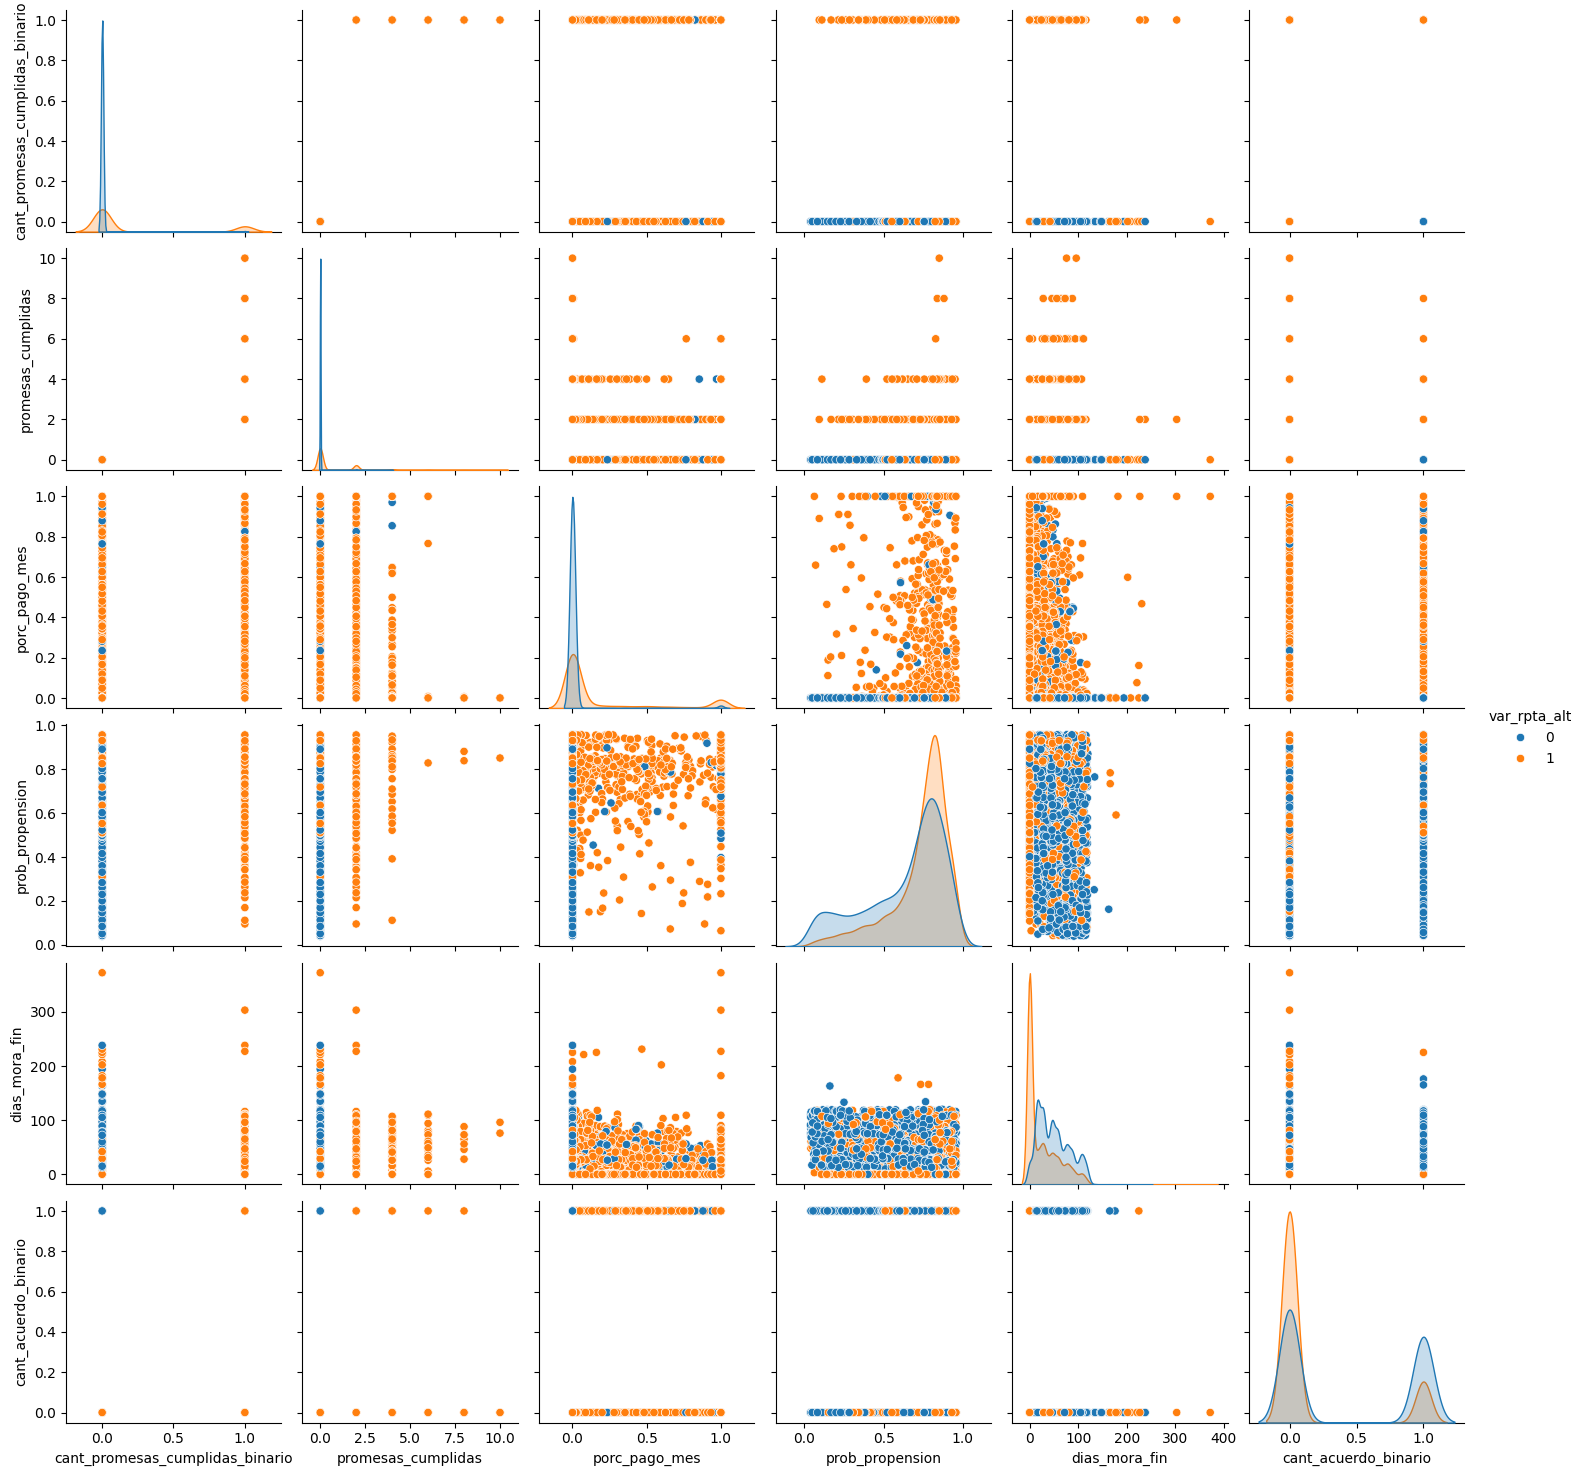

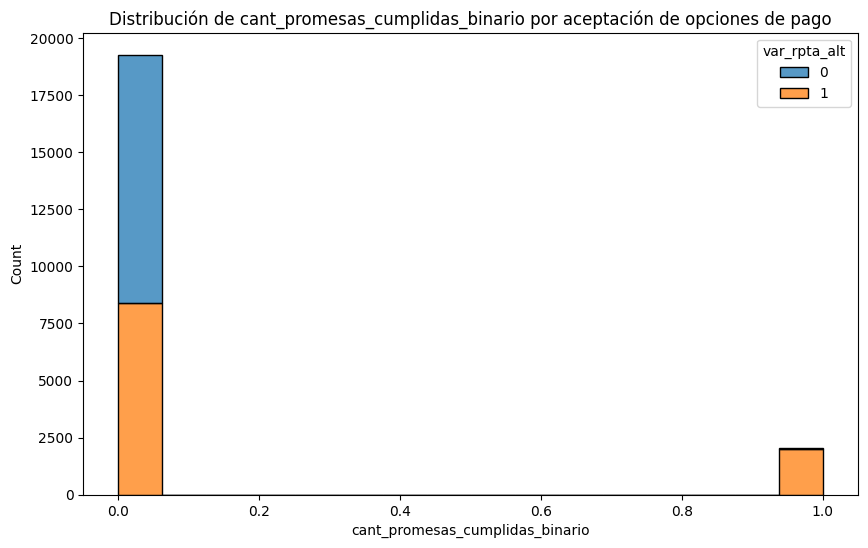

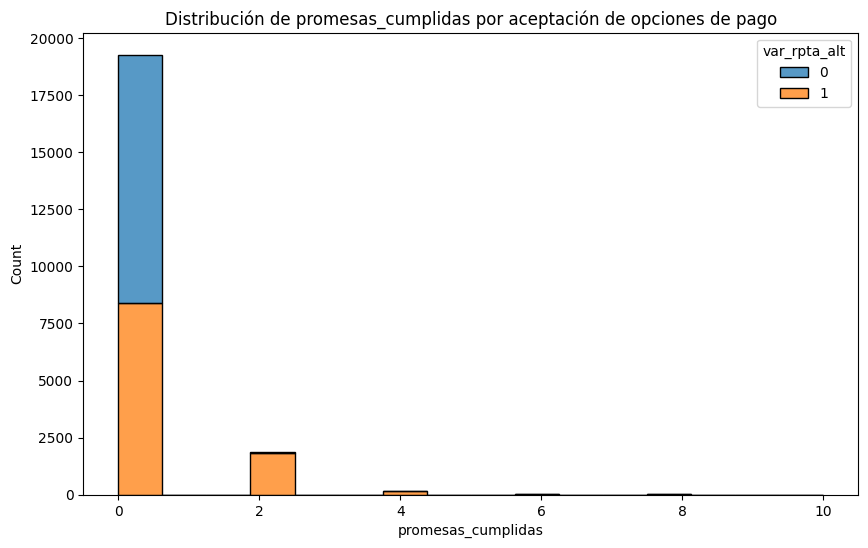

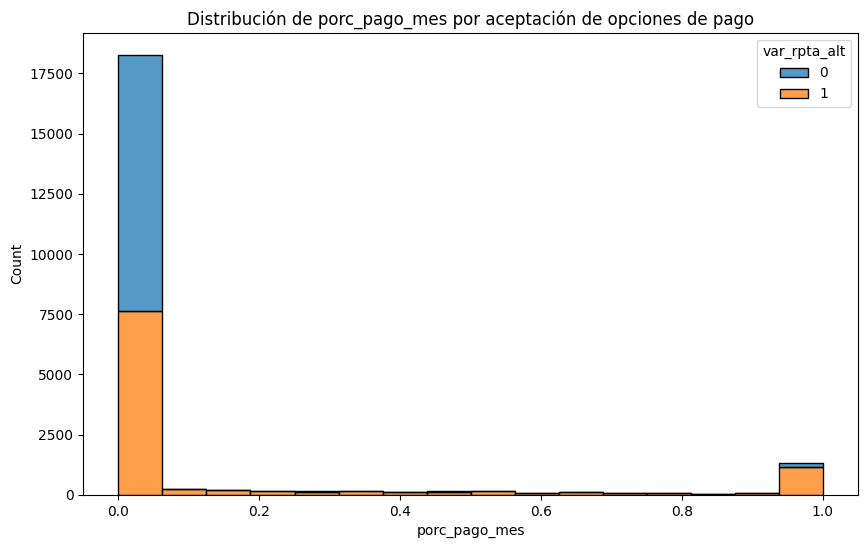

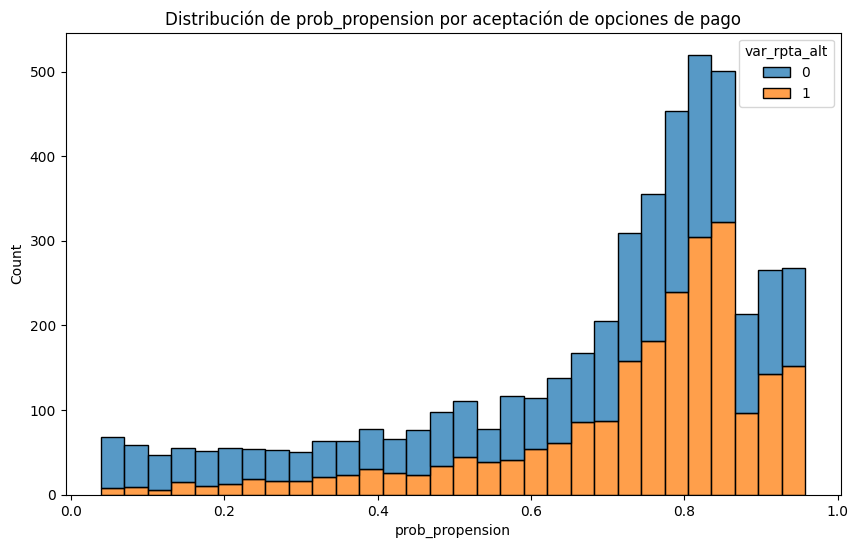

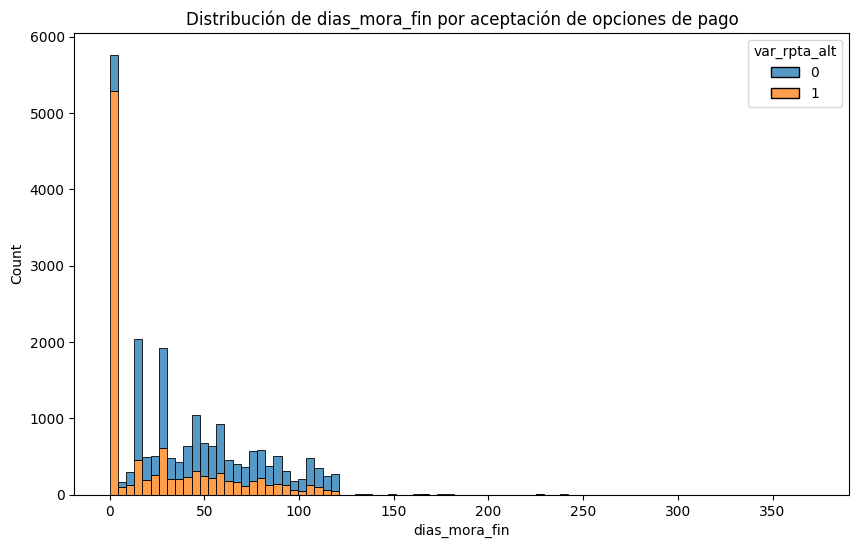

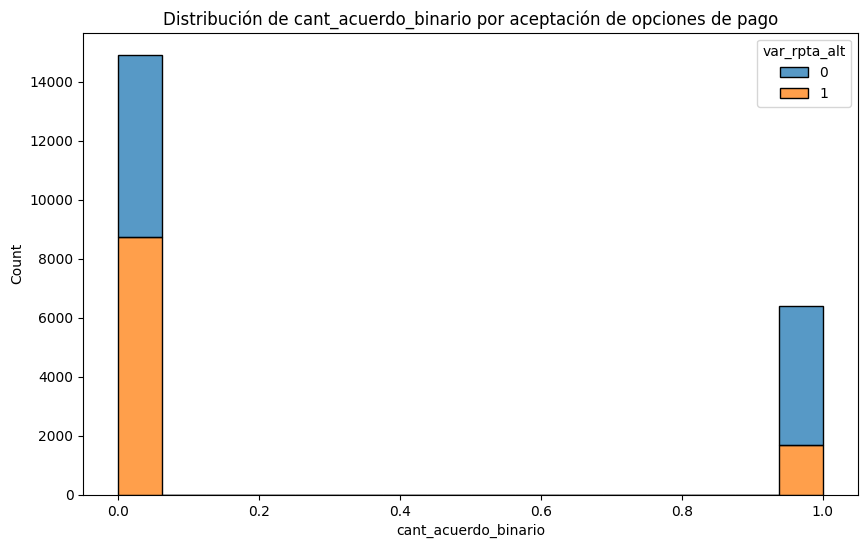

In [16]:
# Variables seleccionadas
selected_vars = [
    'cant_promesas_cumplidas_binario', 'promesas_cumplidas',
    'porc_pago_mes', 'prob_propension', 'dias_mora_fin', 'cant_acuerdo_binario'
]

# Añadir la variable objetivo para facilitar el plot
selected_vars.append('var_rpta_alt')

# Subset del dataframe con las variables seleccionadas
data_subset = train_full[selected_vars]

# Pairplot para visualizar las relaciones entre las variables seleccionadas y la variable objetivo
sns.pairplot(data_subset, hue='var_rpta_alt')
plt.show()

# Gráficos individuales de distribución para cada variable seleccionada
for var in selected_vars[:-1]:  # Excluyendo 'var_rpta_alt'
    plt.figure(figsize=(10, 6))
    sns.histplot(data_subset, x=var, hue='var_rpta_alt', multiple="stack")
    plt.title(f'Distribución de {var} por aceptación de opciones de pago')
    plt.show()

La visualización muestra que los clientes con promesas de pago cumplidas (promesas_cumplidas y cant_promesas_cumplidas_binario), un mayor porcentaje de pago mensual (porc_pago_mes), y una alta probabilidad de propensión (prob_propension) tienden a aceptar opciones de pago (naranja). En contraste, un mayor número de días en mora (dias_mora_fin) y menos acuerdos (cant_acuerdo_binario) están asociados con una menor aceptación (azul). Esto sugiere que el comportamiento de pago pasado y la propensión son fuertes indicadores de la aceptación de opciones de pago.

La gráfica titulada "Distribución de prob_propension por aceptación de opciones de pago" muestra que a medida que aumenta la probabilidad de propensión (prob_propension), también aumenta la cantidad de clientes que aceptan opciones de pago (var_rpta_alt). Específicamente, para valores de prob_propension superiores a 0.6, se observa una mayor proporción de aceptación de opciones de pago (barras naranjas). Esto sugiere que prob_propension es un fuerte predictor de la aceptación de opciones de pago, con mayores probabilidades de aceptación en clientes con alta propensión.


La gráfica titulada "Distribución de porc_pago_mes por aceptación de opciones de pago" muestra que la mayoría de los clientes tienen un porcentaje de pago mensual (porc_pago_mes) cercano a 0.0, y en este grupo, una mayor cantidad no aceptan opciones de pago (barras azules) en comparación con los que sí las aceptan (barras naranjas). A medida que el porcentaje de pago mensual aumenta, especialmente cercano a 1.0, hay una proporción relativamente mayor de clientes que aceptan opciones de pago. Esto sugiere que un mayor porcentaje de pago mensual está asociado con una mayor probabilidad de aceptación de opciones de pago.

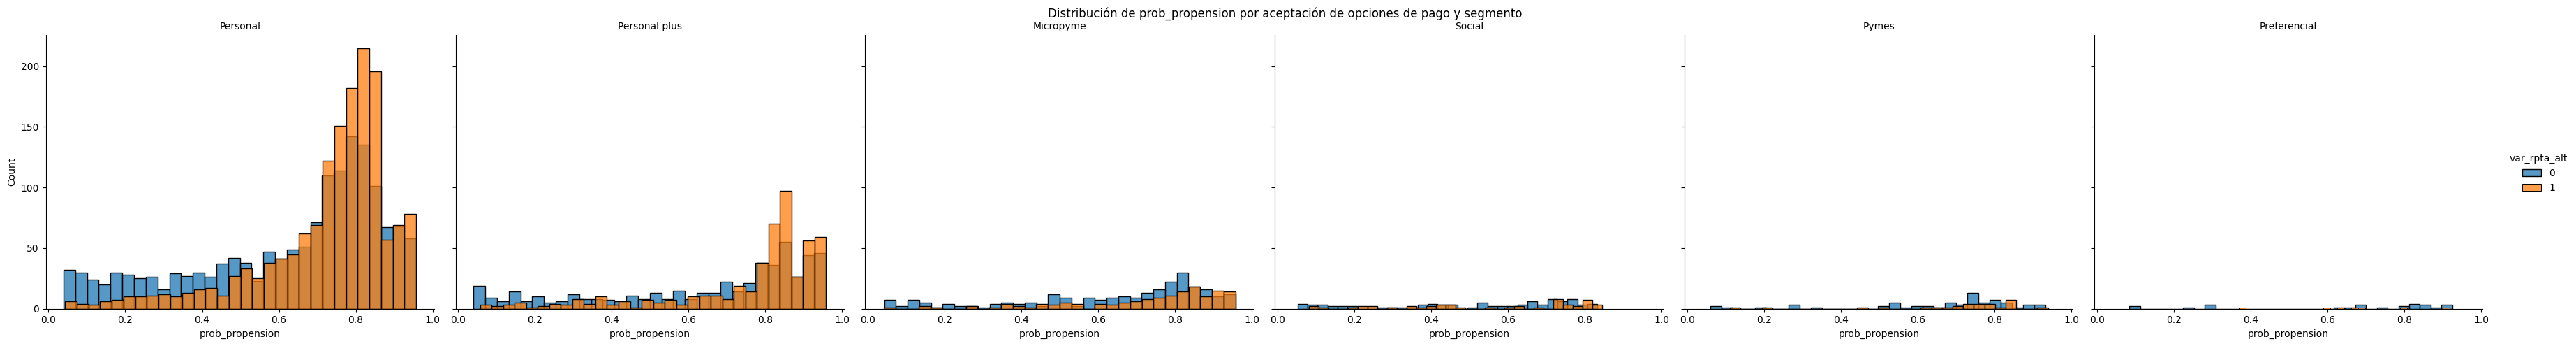

In [17]:


# Asegurarse de que 'segmento_x' y 'prob_propension' están en el DataFrame fusionado
if 'segmento_x' in train_full.columns and 'prob_propension' in train_full.columns:
    g = sns.FacetGrid(train_full, col="segmento_x", hue="var_rpta_alt", height=5, aspect=1.2)
    g.map(sns.histplot, 'prob_propension', multiple="stack", kde=False, bins=30, element="bars", stat="count")
    g.add_legend(title='var_rpta_alt')
    g.set_axis_labels('prob_propension', 'Count')
    g.set_titles(col_template='{col_name}')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Distribución de prob_propension por aceptación de opciones de pago y segmento')
    plt.show()
else:
    print("Las columnas 'segmento_x' y 'prob_propension' no están presentes en el DataFrame.")



### Análisis del Gráfico de Distribución de prob_propension por Segmento

1. **Personal:**
   - Los clientes del segmento "Personal" muestran una clara tendencia a aceptar opciones de pago cuando la `prob_propension` es alta, especialmente en el rango de 0.6 a 1.0. La cantidad de aceptaciones (naranja) supera significativamente a las no aceptaciones (azul) en estos rangos, lo que indica que una alta probabilidad de propensión es un buen predictor de aceptación en este segmento.

2. **Personal plus:**
   - Similar al segmento "Personal", los clientes de "Personal plus" también muestran una mayor aceptación de opciones de pago a medida que aumenta la `prob_propension`, particularmente alrededor del rango de 0.6 a 1.0. La proporción de aceptaciones es mayor en estos rangos, aunque la cantidad total de clientes es menor en comparación con el segmento "Personal".

3. **Micropyme:**
   - En el segmento "Micropyme", la distribución es más dispersa. Aunque se observa una mayor aceptación en los rangos de `prob_propension` altos (0.6 a 1.0), la diferencia entre aceptaciones y no aceptaciones no es tan pronunciada como en los segmentos "Personal" y "Personal plus".

4. **Societal:**
   - Los clientes del segmento "Societal" presentan una distribución más uniforme en términos de aceptación de opciones de pago a través de diferentes rangos de `prob_propension`. Sin embargo, hay una ligera tendencia a mayores aceptaciones en los rangos más altos de probabilidad.

5. **Pymes:**
   - El segmento "Pymes" muestra muy poca variabilidad en la aceptación de opciones de pago, con una baja cantidad de datos en todos los rangos de `prob_propension`. Esto sugiere que la `prob_propension` no es un fuerte predictor en este segmento o que se necesita más data.

6. **Preferencial:**
   - En el segmento "Preferencial", la distribución es bastante uniforme con muy pocos datos en todos los rangos de `prob_propension`. Al igual que con las "Pymes", esto indica que puede haber poca relación entre la `prob_propension` y la aceptación de opciones de pago o que se necesita más data.

En resumen, los segmentos "Personal" y "Personal plus" muestran la relación más clara entre una alta `prob_propension` y la aceptación de opciones de pago, mientras que los segmentos "Micropyme", "Societal", "Pymes" y "Preferencial" presentan distribuciones más dispersas y menos concluyentes.

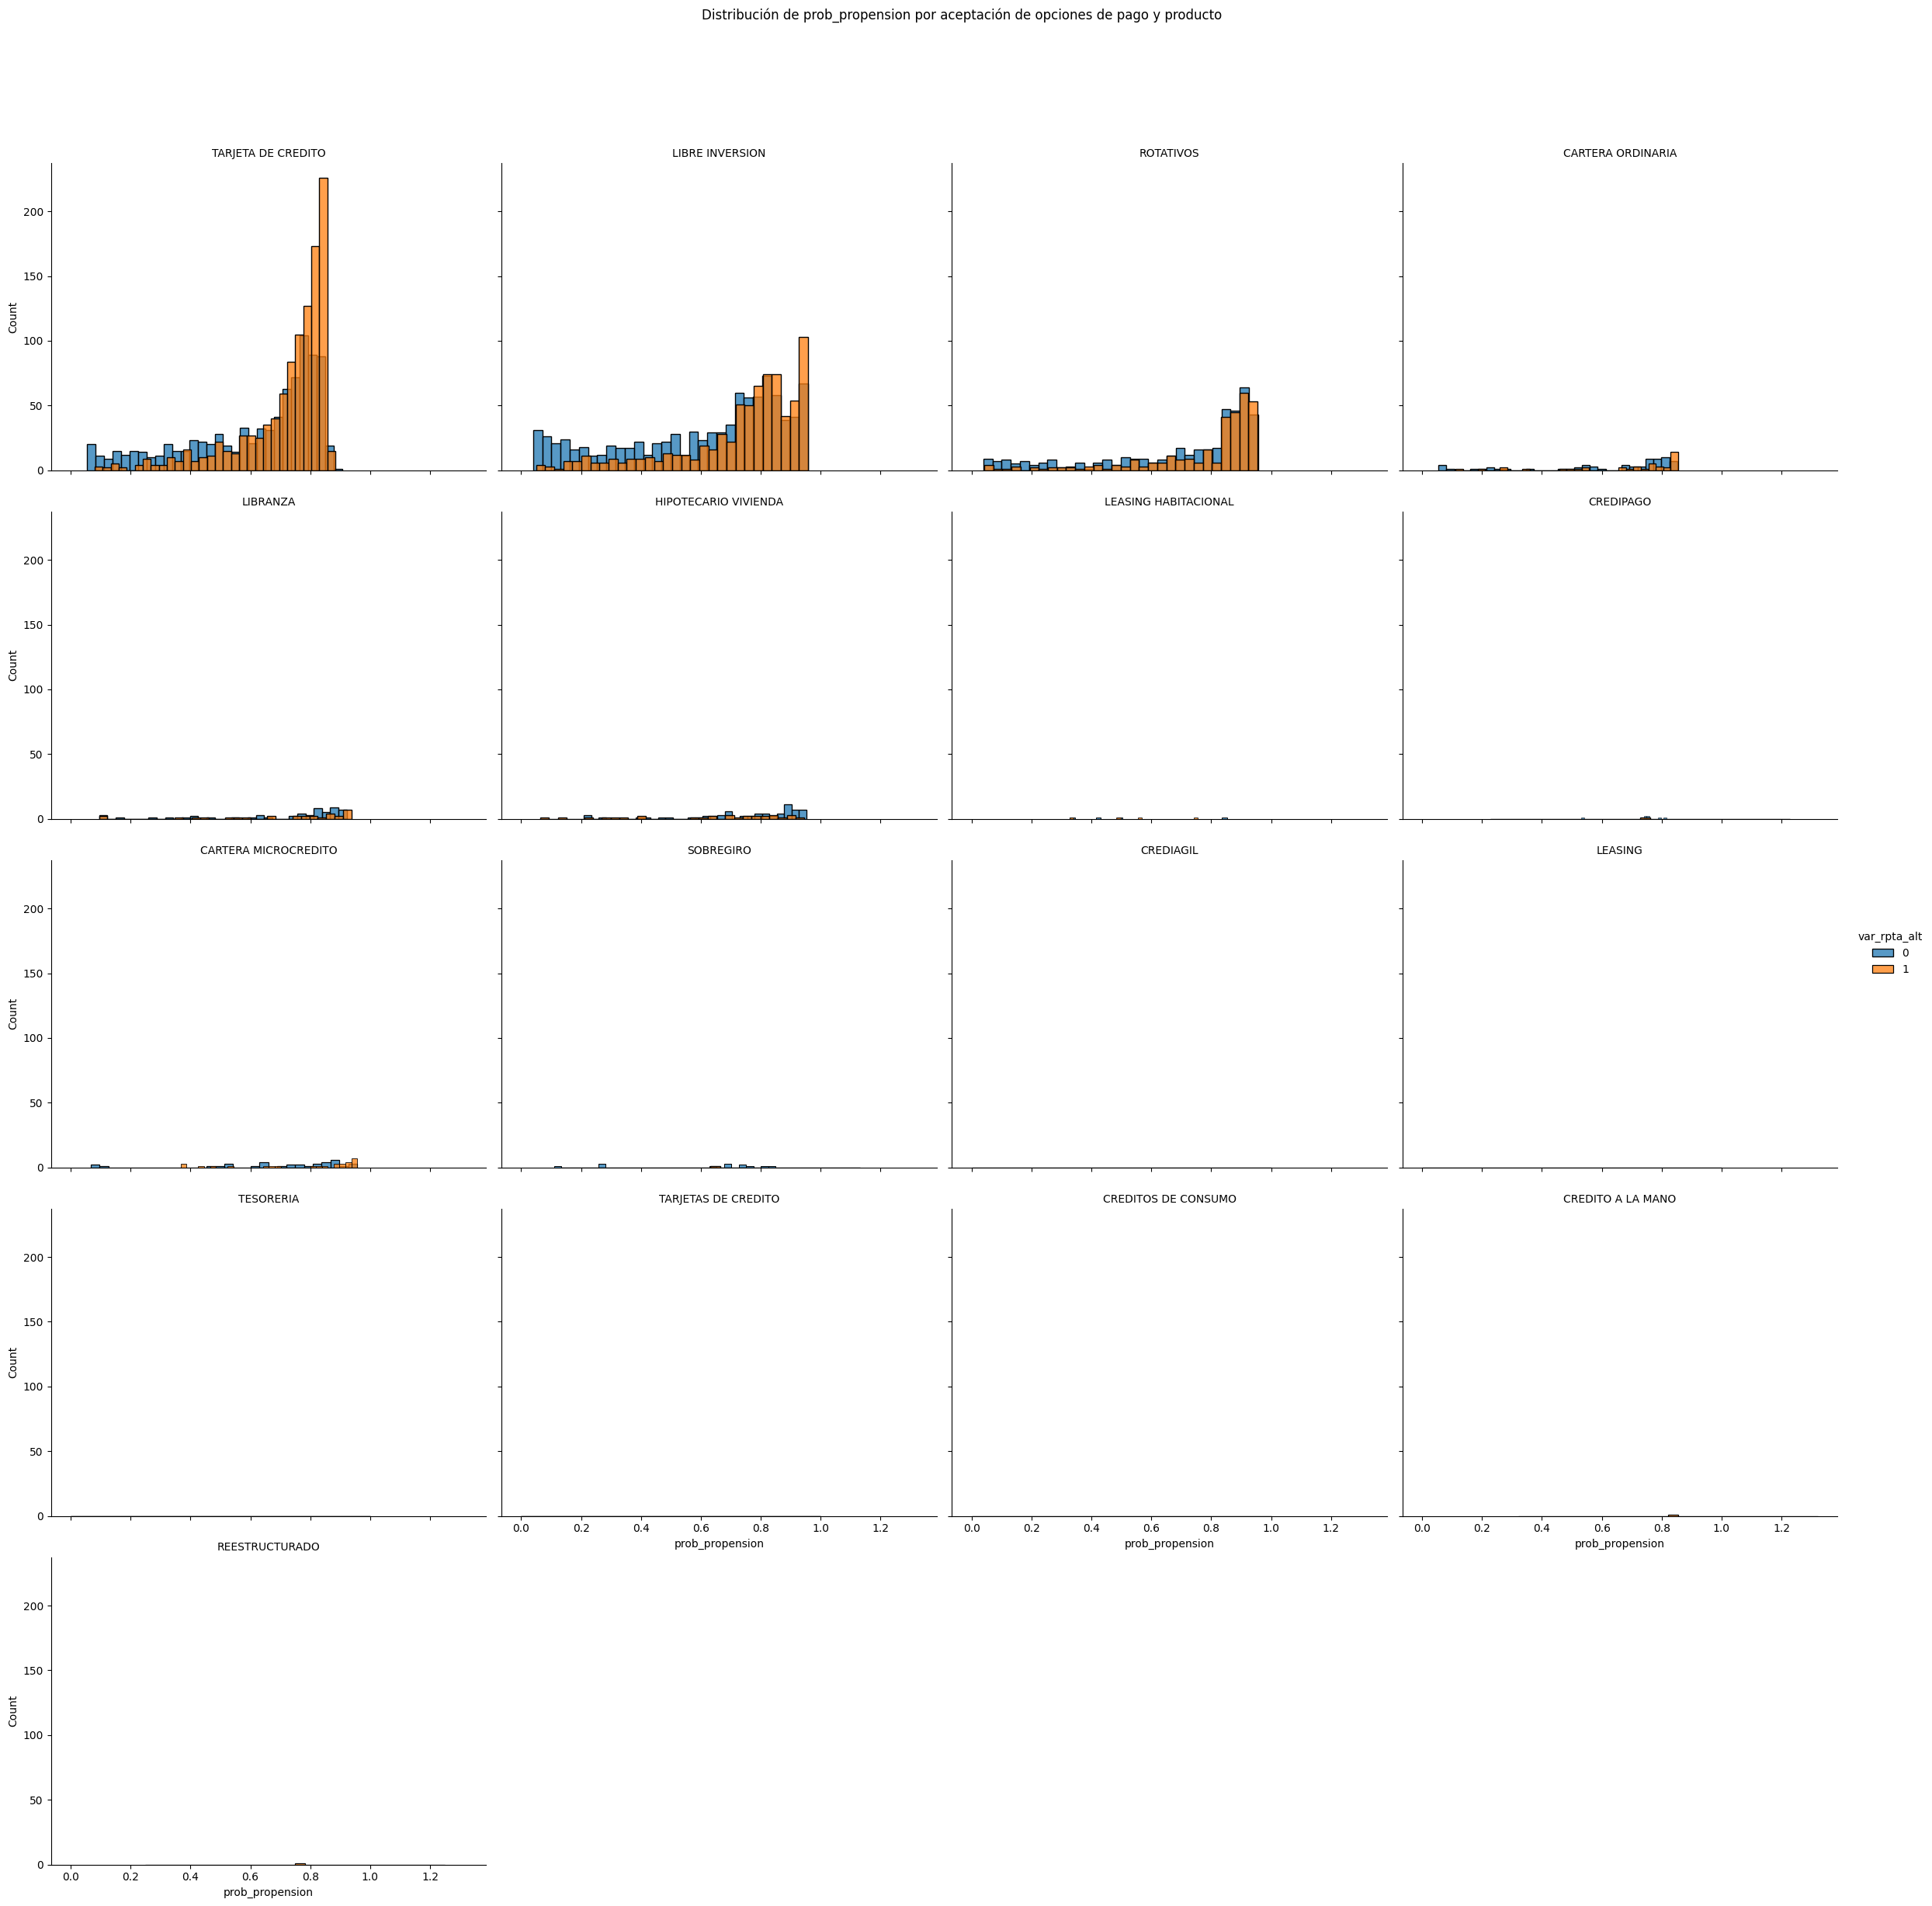

In [18]:
# Se valida  que 'producto_x' y 'prob_propension' están en el DataFrame fusionado
if 'producto_x' in train_full.columns and 'prob_propension' in train_full.columns:
    g = sns.FacetGrid(train_full, col="producto_x", hue="var_rpta_alt", height=5, aspect=1.2, col_wrap=4)
    g.map(sns.histplot, 'prob_propension', multiple="stack", kde=False, bins=30, element="bars", stat="count")
    g.add_legend(title='var_rpta_alt')
    g.set_axis_labels('prob_propension', 'Count')
    g.set_titles(col_template='{col_name}')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Distribución de prob_propension por aceptación de opciones de pago y producto')
    plt.show()
else:
    print("Las columnas 'producto_x' y 'prob_propension' no están presentes en el DataFrame.")


La gráfica "Distribución de prob_propension por aceptación de opciones de pago y producto" muestra que los productos "Tarjeta de Crédito" y "Libre Inversión" tienen una clara tendencia a aceptar opciones de pago cuando la prob_propension es alta, especialmente en el rango de 0.6 a 1.0. Los productos "Rotativos" y "Microcrédito" también muestran una relación positiva pero con menor intensidad. En contraste, productos como "Leasing Habitacional", "Credinom", y "Tesorería" presentan muy baja variabilidad y aceptación, indicando que la probabilidad de propensión no es un fuerte predictor para estos productos.

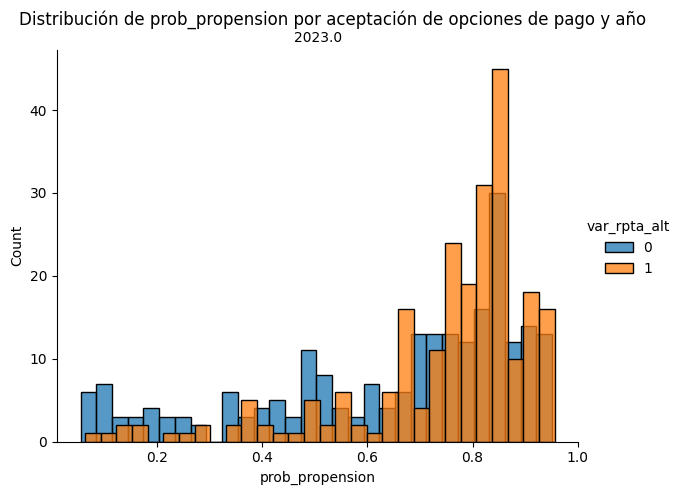

In [19]:


# Se valida que 'year' y 'prob_propension' están en el DataFrame fusionado
if 'year' in train_full.columns and 'prob_propension' in train_full.columns:
    g = sns.FacetGrid(train_full, col="year", hue="var_rpta_alt", height=5, aspect=1.2)
    g.map(sns.histplot, 'prob_propension', multiple="stack", kde=False, bins=30, element="bars", stat="count")
    g.add_legend(title='var_rpta_alt')
    g.set_axis_labels('prob_propension', 'Count')
    g.set_titles(col_template='{col_name}')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Distribución de prob_propension por aceptación de opciones de pago y año')
    plt.show()
else:
    print("Las columnas 'year' y 'prob_propension' no están presentes en el DataFrame.")


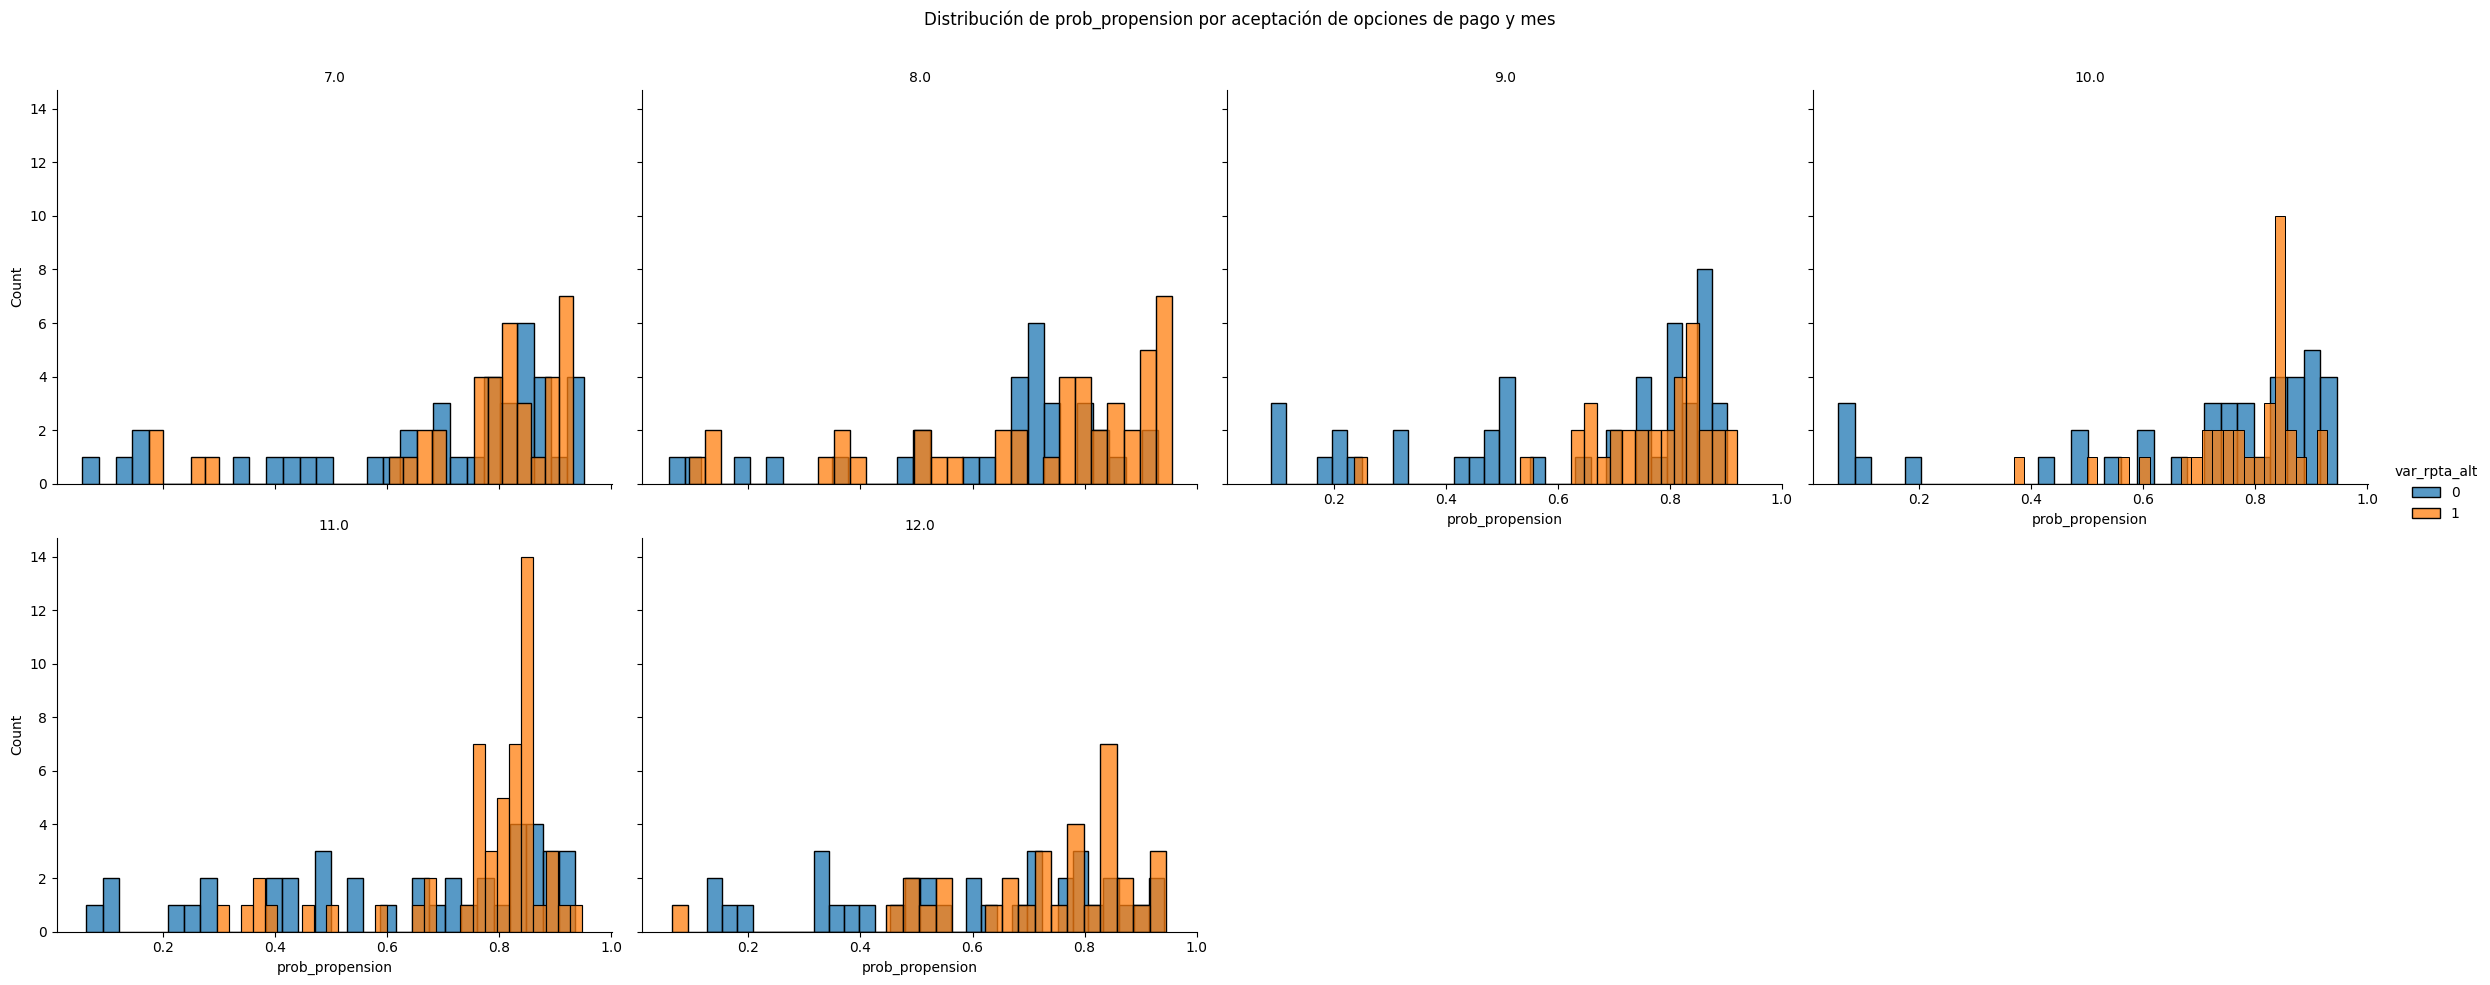

In [20]:
# Se valida que 'month' y 'prob_propension' están en el DataFrame fusionado
if 'month' in train_full.columns and 'prob_propension' in train_full.columns:
    g = sns.FacetGrid(train_full, col="month", hue="var_rpta_alt", height=5, aspect=1.2, col_wrap=4)
    g.map(sns.histplot, 'prob_propension', multiple="stack", kde=False, bins=30, element="bars", stat="count")
    g.add_legend(title='var_rpta_alt')
    g.set_axis_labels('prob_propension', 'Count')
    g.set_titles(col_template='{col_name}')
    plt.subplots_adjust(top=0.9)
    g.fig.suptitle('Distribución de prob_propension por aceptación de opciones de pago y mes')
    plt.show()
else:
    print("Las columnas 'month' y 'prob_propension' no están presentes en el DataFrame.")


La gráfica muestra la distribución de la probabilidad de aceptación (prob_propension) de opciones de pago segmentada por mes para un período determinado. Se observa que en los meses con alta probabilidad de propensión (por encima de 0.6), hay una mayor cantidad de aceptaciones de opciones de pago (barras naranjas) en comparación con las no aceptaciones (barras azules). Esta tendencia es más pronunciada en ciertos meses, como en el mes 7 y 8, donde los clientes con alta probabilidad de propensión muestran una clara tendencia a aceptar opciones de pago. Esto sugiere una fuerte relación entre la prob_propension y la aceptación de opciones de pago en ciertos meses.

El comportamiento observado en los meses 7 y 8, donde hay una mayor aceptación de opciones de pago, podría estar asociado a factores tales como durante estos meses, muchas personas reciben primas y bonificaciones de mitad de año, lo cual aumenta su capacidad de pago. Además, estos meses coinciden con la temporada de vacaciones, lo que podría motivar a las personas a regularizar sus deudas para poder disfrutar de sus vacaciones sin preocupaciones financieras. Este contexto financiero y cultural puede influir significativamente en el comportamiento de pago de los clientes.

# 7.Balanceo del Dataset

In [21]:
# Verificar el balance de la variable objetivo
print("\nDistribución de la variable objetivo en el dataset de entrenamiento:")
print(train_full['var_rpta_alt'].value_counts())

# Balanceo del dataset usando sobremuestreo o submuestreo si es necesario
from sklearn.utils import resample

# Separar las clases
class_0 = train_full[train_full['var_rpta_alt'] == 0]
class_1 = train_full[train_full['var_rpta_alt'] == 1]

# Sobremuestreo de la clase minoritaria
class_1_upsampled = resample(class_1, replace=True, n_samples=len(class_0), random_state=42)
train_full_balanced = pd.concat([class_0, class_1_upsampled])

# Verificar la nueva distribución de la variable objetivo
print("\nDistribución de la variable objetivo después del balanceo:")
print(train_full_balanced['var_rpta_alt'].value_counts())



Distribución de la variable objetivo en el dataset de entrenamiento:
var_rpta_alt
0    10911
1    10414
Name: count, dtype: int64

Distribución de la variable objetivo después del balanceo:
var_rpta_alt
0    10911
1    10911
Name: count, dtype: int64


La distribución de la variable objetivo var_rpta_alt en el dataset de entrenamiento muestra un ligero desbalance, con 9469 casos de 0 y 9009 casos de 1. Después del balanceo, ambos casos tienen exactamente 9469 ejemplos, logrando una distribución equilibrada. Este balanceo es crucial para asegurar que el modelo no esté sesgado hacia la clase mayoritaria. Con esta distribución equilibrada, puedes proceder a la selección y normalización de características, ya que el balanceo garantiza que el modelo aprenda de manera justa de ambas clases.

# 8.Selección y Normalización de Características




In [22]:
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Separar características y etiqueta
X = train_full_balanced.drop('var_rpta_alt', axis=1)
y = train_full_balanced['var_rpta_alt']

# Definir las columnas categóricas y numéricas
numeric_features = X.select_dtypes(include=[np.number]).columns
categorical_features = X.select_dtypes(include=['object']).columns

# Transformación de datos
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])


In [26]:
# Asegurar que todas las columnas categóricas sean de tipo string
for col in X.select_dtypes(include=['object']).columns:
    X[col] = X[col].astype(str)

# Dividir el conjunto de datos en entrenamiento y validación
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

9.Construcción y Entrenamiento del Modelo

In [27]:
# Definir las columnas categóricas y numéricas
numeric_features = X_train.select_dtypes(include=[np.number]).columns
categorical_features = X_train.select_dtypes(include=['object']).columns

# Verificar y reemplazar valores infinitos y NaN en las columnas numéricas
X_train[numeric_features] = X_train[numeric_features].replace([np.inf, -np.inf], np.nan)
X_train[numeric_features] = X_train[numeric_features].fillna(X_train[numeric_features].mean())

X_val[numeric_features] = X_val[numeric_features].replace([np.inf, -np.inf], np.nan)
X_val[numeric_features] = X_val[numeric_features].fillna(X_val[numeric_features].mean())

# Transformación de datos
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Crear pipeline con preprocesador y modelo
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', XGBClassifier(random_state=42))])

# Entrenar el modelo
model.fit(X_train, y_train)

# Evaluar el modelo
y_pred = model.predict(X_val)
y_pred_proba = model.predict_proba(X_val)[:, 1]

print("\nReporte de clasificación:")
print(classification_report(y_val, y_pred))
print("\nAUC-ROC:", roc_auc_score(y_val, y_pred_proba))

# Matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)



Reporte de clasificación:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2194
           1       1.00      1.00      1.00      2171

    accuracy                           1.00      4365
   macro avg       1.00      1.00      1.00      4365
weighted avg       1.00      1.00      1.00      4365


AUC-ROC: 1.0

Matriz de Confusión:
[[2194    0]
 [   0 2171]]


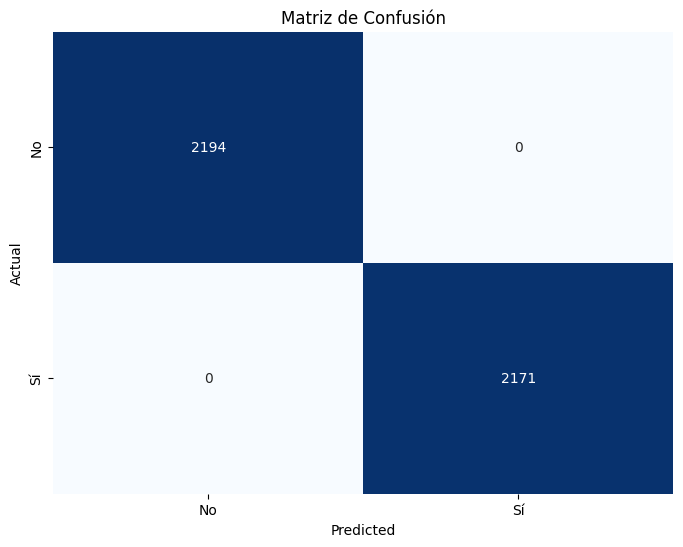

In [28]:
from sklearn.metrics import confusion_matrix


y_pred = model.predict(X_val)

# Generar la matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred)

# Graficar la matriz de confusión
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['No', 'Sí'], yticklabels=['No', 'Sí'])
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Matriz de Confusión')
plt.show()

La matriz de confusión muestra que el modelo ha clasificado correctamente todas las instancias tanto de la clase "No" (2194) como de la clase "Sí" (2171).

In [29]:
# Calcular el F1 score
f1 = f1_score(y_val, y_pred)

# Mostrar el F1 score
print(f"F1 Score: {f1}")

F1 Score: 1.0


# 10.Evaluación del Modelo

In [30]:
# Matriz de confusión
conf_matrix = confusion_matrix(y_val, y_pred)
print("\nMatriz de Confusión:")
print(conf_matrix)

# Importancia de características
importances = model.named_steps['classifier'].feature_importances_
features = numeric_features.tolist() + list(model.named_steps['preprocessor'].transformers_[1][1].named_steps['encoder'].get_feature_names_out(categorical_features))

feature_importances = pd.DataFrame(importances, index=features, columns=['importance']).sort_values('importance', ascending=False)
print("\nImportancia de características:")
print(feature_importances)



Matriz de Confusión:
[[2194    0]
 [   0 2171]]

Importancia de características:
                                                    importance
tipo_var_rpta_alt_e_cero_tipo_2                       0.800189
tipo_var_rpta_alt_d_cero_tipo_1                       0.166421
marca_alternativa_Acepta Alternativa                  0.026753
tipo_var_rpta_alt_c_uno_tipo_3                        0.004884
descripcion_ranking_mejor_ult_INTERESADO ALTERN...    0.001327
...                                                        ...
nit_enmascarado_493045                                0.000000
nit_enmascarado_492982                                0.000000
nit_enmascarado_492907                                0.000000
nit_enmascarado_492817                                0.000000
nit_enmascarado_493561                                0.000000

[26148 rows x 1 columns]


# 12.Predicciones en el Conjunto OOT

In [53]:



# Asegurar que todas las columnas categóricas sean de tipo string en X_train y X_oot
categorical_features = X.select_dtypes(include=['object']).columns
for col in categorical_features:
    X_oot[col] = X_oot[col].astype(str)
    X_train[col] = X_train[col].astype(str)

# Convertir columnas numéricas a tipo numérico en X_oot
numeric_features = X.select_dtypes(include=[np.number]).columns
for col in numeric_features:
    X_oot[col] = pd.to_numeric(X_oot[col], errors='coerce')

# Reemplazar valores infinitos y NaN en las columnas numéricas
X_oot[numeric_features] = X_oot[numeric_features].replace([np.inf, -np.inf], np.nan)
X_oot[numeric_features] = X_oot[numeric_features].fillna(X_oot[numeric_features].mean())

# Asegurar que todas las columnas necesarias están presentes en X_oot
missing_cols = [col for col in X_train.columns if col not in X_oot.columns]
if missing_cols:
    print(f"Faltan las siguientes columnas en 'X_oot': {missing_cols}")
    for col in missing_cols:
        X_oot[col] = 0  # Rellenar columnas faltantes con ceros

# Asegurar que las columnas estén en el mismo orden
X_oot = X_oot[X_train.columns]

# Transformación de datos
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

categorical_transformer = Pipeline(steps=[
    ('encoder', OneHotEncoder(handle_unknown='ignore'))])

preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', categorical_transformer, categorical_features)])

# Crear pipeline con preprocesador y modelo
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', XGBClassifier(random_state=42))])

# Ajustar el preprocesador y el modelo
model.fit(X_train, y_train)

# Aplicar el preprocesador al conjunto OOT
X_oot_transformed = model.named_steps['preprocessor'].transform(X_oot)

# Verificar dimensiones de X_oot_transformed y X_train_transformed para asegurar consistencia
X_train_transformed = model.named_steps['preprocessor'].transform(X_train)
print(f"Dimensiones de X_train_transformed: {X_train_transformed.shape}")
print(f"Dimensiones de X_oot_transformed: {X_oot_transformed.shape}")

# Asegurarse de que las dimensiones coincidan
if X_oot_transformed.shape[1] == X_train_transformed.shape[1]:
    # Hacer predicciones en el conjunto OOT
    oot_pred = model.named_steps['classifier'].predict(X_oot_transformed)
    oot_pred_proba = model.named_steps['classifier'].predict_proba(X_oot_transformed)[:, 1]

    # Asegurarse de que las columnas sean de tipo string para concatenar
    X_oot[['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado']] = X_oot[['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado']].astype(str)

    # Crear el DataFrame de resultados
    oot_results = X_oot[['nit_enmascarado', 'num_oblig_orig_enmascarado', 'num_oblig_enmascarado']].copy()
    oot_results['ID'] = oot_results['nit_enmascarado'] + '#' + oot_results['num_oblig_orig_enmascarado'] + '#' + oot_results['num_oblig_enmascarado']
    oot_results['var_rpta_alt'] = oot_pred
    oot_results['Prob_uno'] = oot_pred_proba

    # Seleccionar y ordenar las columnas finales
    oot_results_final = oot_results[['ID', 'var_rpta_alt', 'Prob_uno']]

     # Guardar los resultados en un archivo CSV
    oot_results_final.to_csv('/content/sample_data/resultado_prueba.csv', index=False, encoding='utf-8')

    print("Archivo 'resultado_generales.csv' creado exitosamente.")
else:
    print("Las dimensiones de X_oot_transformed no coinciden con las de X_train_transformed. Verifique las columnas y el preprocesamiento.")



Dimensiones de X_train_transformed: (17457, 26148)
Dimensiones de X_oot_transformed: (117011, 26148)
Archivo 'resultado_prueba.csv' creado exitosamente.


In [56]:


# Cargar los datos
sample_submission = pd.read_csv('/content/sample_data/sample_submission.csv')
resultado_prueba = pd.read_csv('/content/sample_data/resultado_prueba.csv')

# Mostrar las primeras filas de ambos DataFrames
print("sample_submission:\n", sample_submission.head())
print("resultado_prueba:\n", resultado_prueba.head())

# Asegurarse de que la columna 'ID' esté presente en ambos DataFrames
if 'ID' not in sample_submission.columns or 'ID' not in resultado_prueba.columns:
    raise KeyError("La columna 'ID' no está presente en uno de los DataFrames.")

# Unir los DataFrames en base a la columna 'ID'
merged_df = pd.merge(sample_submission[['ID']], resultado_prueba[['ID', 'var_rpta_alt']], on='ID', how='left')

# Verificar la unión
print("\nDatos unidos:")
print(merged_df.head())

# Guardar los resultados en un nuevo archivo CSV
output_file_path = '/content/sample_data/resultados_prueba_.csv'
merged_df.to_csv(output_file_path, index=False, encoding='utf-8')

print(f"Archivo 'sample_submission_con_resultados.csv' creado exitosamente en {output_file_path}.")


sample_submission:
                      ID  var_rpta_alt
0  243031#516680#563662             1
1  401665#347465#733256             0
2  391362#511160#569182             0
3  169789#441265#639051             0
4  341343#76559#1028512             0
resultado_prueba:
                      ID  var_rpta_alt  Prob_uno
0  257335#444821#635511             1  0.991894
1   59584#350400#730364             1  0.991894
2   59584#350400#730364             1  0.991894
3  397604#973821#106521             1  0.991884
4  368086#382995#696856             1  0.991894

Datos unidos:
                     ID  var_rpta_alt
0  243031#516680#563662             1
1  401665#347465#733256             1
2  391362#511160#569182             1
3  169789#441265#639051             1
4  341343#76559#1028512             1
Archivo 'sample_submission_con_resultados.csv' creado exitosamente en /content/sample_data/sample_submission_con_resultados.csv.


# 13.Evaluación del Modelo por Segmento de Cliente

Para evaluar el modelo de manera más detallada, podemos analizar el rendimiento por diferentes segmentos de clientes.

Dividir el conjunto de validación en segmentos y evaluar:

In [33]:
# Definir segmentos basados en la característica 'segmento_x'
if 'segmento_x' in X_val.columns:
    segments = X_val['segmento_x'].unique()

    for segment in segments:
        X_val_segment = X_val[X_val['segmento_x'] == segment]
        y_val_segment = y_val[X_val['segmento_x'] == segment]

        y_pred_segment = model.predict(X_val_segment)
        y_pred_proba_segment = model.predict_proba(X_val_segment)[:, 1]

        print(f"\nSegmento: {segment}")
        print(classification_report(y_val_segment, y_pred_segment))
        print("AUC-ROC:", roc_auc_score(y_val_segment, y_pred_proba_segment))
        print("Matriz de Confusión:")
        print(confusion_matrix(y_val_segment, y_pred_segment))
else:
    print("No se encontró la columna 'segmento_x' en los datos de validación.")




Segmento: Personal
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      1404
           1       1.00      1.00      1.00      1501

    accuracy                           1.00      2905
   macro avg       1.00      1.00      1.00      2905
weighted avg       1.00      1.00      1.00      2905

AUC-ROC: 1.0
Matriz de Confusión:
[[1404    0]
 [   0 1501]]

Segmento: Micropyme
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       213
           1       1.00      1.00      1.00       134

    accuracy                           1.00       347
   macro avg       1.00      1.00      1.00       347
weighted avg       1.00      1.00      1.00       347

AUC-ROC: 1.0
Matriz de Confusión:
[[213   0]
 [  0 134]]

Segmento: Social
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        82
           1       1.00      1.00      1.00        68

    a